In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix, \
classification_report, precision_recall_curve, recall_score, auc, roc_curve, precision_recall_fscore_support, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

plt.style.use('fivethirtyeight')
%matplotlib inline

/anaconda3/envs/work_3.7/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [2]:
tf.__version__

'1.13.1'

In [3]:
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [71]:
df['step'].value_counts()

19     3946
187    3900
18     3890
235    3706
307    3630
15     3584
163    3580
139    3579
186    3552
43     3549
305    3543
403    3513
17     3490
36     3466
355    3463
304    3460
14     3413
16     3389
402    3358
354    3356
42     3325
306    3318
259    3289
379    3244
162    3242
331    3200
13     3200
188    3101
44     3054
20     3040
       ... 
543       3
623       3
626       3
87        3
113       3
655       2
114       2
76        2
593       2
693       2
124       2
708       2
706       2
622       2
539       2
28        2
29        2
293       2
246       2
245       2
432       2
729       2
435       2
725       2
721       2
54        2
197       2
627       2
662       1
112       1
Name: step, Length: 743, dtype: int64

In [3]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [4]:
df.groupby(['type','isFraud']).type.count()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: type, dtype: int64

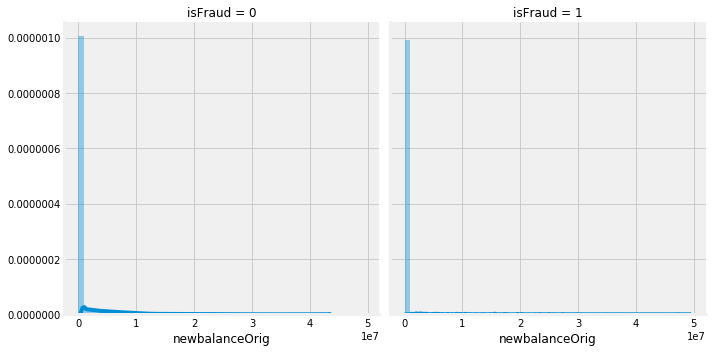

In [7]:
# sns.distplot(df[df['isFraud']==1]['step'])

g = sns.FacetGrid(df, col="isFraud", height=5)
g = g.map(sns.distplot, "newbalanceOrig")  #, bins=bins, color="m")

In [5]:
(df.loc[df['type'] == 'CASH_OUT'].nameDest.str.contains('M')).any() # no merchants in CASH_OUT

False

In [6]:
df[(df['isFraud'] == 1) & (df['type'] =='TRANSFER')]['nameDest']\
.isin(df[(df['isFraud'] == 1) & (df['type'] =='CASH_OUT')]['nameOrig']).any()

False

In [ ]:
# ignore isFlaggedFraud, nameOrig, nameDest cols as they are not significant 

In [8]:
# df = df.loc[(df.type == 'CASH_OUT') | (df.type == 'TRANSFER')]
df = df[df['type']=='TRANSFER']

# Y = X['isFraud']
# del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'type'], axis = 1)

# Binary-encoding of labelled data in 'type'
# df.loc[df['type'] == 'TRANSFER', 'type'] = 0
# df.loc[df['type'] == 'CASH_OUT', 'type'] = 1
# df['type'] = df['type'].astype(int) # convert dtype('O') to dtype(int)

In [9]:
print((sum(df['isFraud']) / len(df)))

0.007687991758442811


In [10]:
# new feature !
# there is an error in calculating balance from the dataset

df['errorBalanceOrig'] = df['newbalanceDest'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [11]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
2,1,181.00,181.00,0.0,0.00,0.00,1,0.00,181.00
19,1,215310.30,705.00,0.0,22425.00,0.00,0,214605.30,237735.30
24,1,311685.89,10835.00,0.0,6267.00,2719172.89,0,3020023.78,-2401220.00
58,1,62610.80,79114.00,16503.2,517.00,8383.29,0,-8119.91,54744.51
78,1,42712.39,10363.39,0.0,57901.66,24044.18,0,56393.18,76569.87


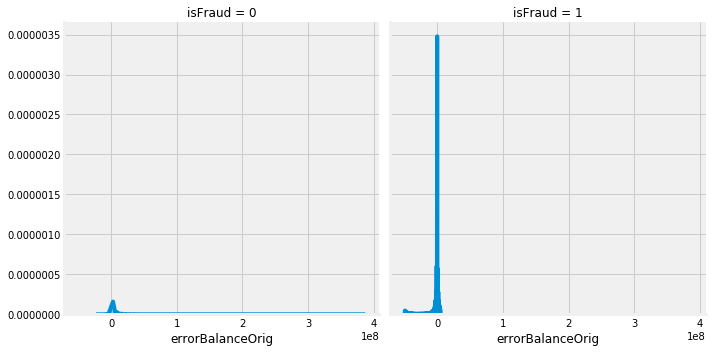

In [16]:
g = sns.FacetGrid(df, col="isFraud", height=5)
g = g.map(sns.distplot, "errorBalanceOrig")  #, bins=bins, color="m")

## autoencoder

In [17]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)

df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

df_train_0 = df_train.loc[df['isFraud'] == 0]
df_train_1 = df_train.loc[df['isFraud'] == 1]
df_train_0_x = df_train_0.drop(['isFraud'], axis=1)
df_train_1_x = df_train_1.drop(['isFraud'], axis=1)

df_valid_0 = df_valid.loc[df['isFraud'] == 0]
df_valid_1 = df_valid.loc[df['isFraud'] == 1]
df_valid_0_x = df_valid_0.drop(['isFraud'], axis=1)
df_valid_1_x = df_valid_1.drop(['isFraud'], axis=1)

df_test_0 = df_test.loc[df['isFraud'] == 0]
df_test_1 = df_test.loc[df['isFraud'] == 1]
df_test_0_x = df_test_0.drop(['isFraud'], axis=1)
df_test_1_x = df_test_1.drop(['isFraud'], axis=1)

In [18]:
print(df_train_0.shape)
print(df_valid_0.shape)
print(df_test_0.shape)

(338482, 9)
(84585, 9)
(105745, 9)


In [16]:
# df_valid_0_x.head(3)

In [19]:
scaler = StandardScaler().fit(df_train_0_x)

df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['isFraud'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['isFraud'], axis = 1))

/anaconda3/envs/work_3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/work_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/work_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/anaconda3/envs/work_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/envs/work_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dt

In [88]:
df_train_0_x_rescaled[0:3,]

array([[-1.45636808, -0.21385599, -0.28395966, -0.07396141, -0.08130996,
        -0.13210761],
       [-1.59510873, -0.34815097, -0.28395966, -0.07396141, -0.00282217,
         0.16218043],
       [ 0.26401598, -0.27514111, -0.15711715, -0.07396141, -0.35717371,
        -0.37273908]])

In [57]:
nb_epoch = 30
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] # num of predictor variables, 
encoding_dim = 8  # total features = 9 
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))

# TODO tanh or relu? 
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
# encoder = Dense(int(hidden_dim*2), activation="tanh")(encoder)
encoder = Dense(hidden_dim, activation="elu")(encoder)

decoder = Dense(hidden_dim, activation='tanh')(encoder)  # tanh
# decoder = Dense(int(hidden_dim*2), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [58]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled, 
                          epochs=nb_epoch, 
                          batch_size=batch_size, 
                          shuffle=True,
                          validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                          verbose=1,
                          callbacks=[cp, tb]).history

Train on 338482 samples, validate on 84585 samples
Epoch 1/30
338482/338482 [==============================] - 3s 10us/step - loss: 0.5776 - acc: 0.7325 - val_loss: 0.4103 - val_acc: 0.8759
Epoch 2/30
338482/338482 [==============================] - 3s 9us/step - loss: 0.3794 - acc: 0.8833 - val_loss: 0.3491 - val_acc: 0.8799
Epoch 3/30
338482/338482 [==============================] - 3s 9us/step - loss: 0.3371 - acc: 0.8874 - val_loss: 0.3197 - val_acc: 0.8848
Epoch 4/30
338482/338482 [==============================] - 3s 9us/step - loss: 0.3155 - acc: 0.8882 - val_loss: 0.3038 - val_acc: 0.8939
Epoch 5/30
338482/338482 [==============================] - 3s 9us/step - loss: 0.3018 - acc: 0.8897 - val_loss: 0.2911 - val_acc: 0.8823
Epoch 6/30
338482/338482 [==============================] - 3s 10us/step - loss: 0.2919 - acc: 0.8914 - val_loss: 0.2807 - val_acc: 0.8974
Epoch 7/30
338482/338482 [==============================] - 3s 9us/step - loss: 0.2851 - acc: 0.8919 - val_loss: 0.2747

In [25]:
# TODO load saved model

autoencoder = load_model('autoencoder_classifier.h5')

In [27]:
history

{'val_loss': [0.6630562547156311,
  0.6529519980190324,
  0.6504876398325685,
  0.6483938576321854,
  0.6480204324166269,
  0.6472898006969474,
  0.6489036869955533,
  0.6471878466148738,
  0.6479401341074675,
  0.6467373647533453,
  0.6464551255498899,
  0.6461330895656924,
  0.646169114134875,
  0.6466663583151244,
  0.6461808465926361,
  0.6458986542661358,
  0.6459542349316504,
  0.6469094587656992,
  0.646547384878884,
  0.6459106815574249,
  0.6456031839225481,
  0.6456178766156424,
  0.6477147580775984,
  0.645640782734625,
  0.6457617756938754,
  0.6455397360133859,
  0.6459758204141041,
  0.6464137610982846,
  0.6457148683628179,
  0.6457183875269928],
 'val_acc': [0.8723887214108463,
  0.8932198380369761,
  0.9137081042773307,
  0.898977360057656,
  0.9005379204407027,
  0.9020275462608836,
  0.8894484837793561,
  0.9133297866094181,
  0.903245256256041,
  0.9118165159328346,
  0.9059171247899466,
  0.9042856298454435,
  0.9125495064164855,
  0.9064018443021579,
  0.906520068

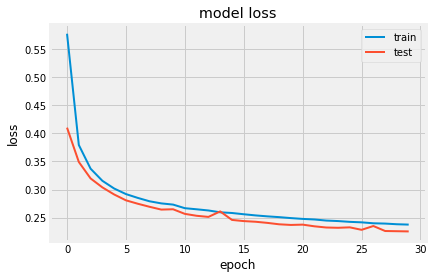

In [59]:
plt.plot(history['loss'], linewidth=2)
plt.plot(history['val_loss'], linewidth=2)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [60]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)

mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['isFraud']})

error_df.head(3)

,Reconstruction_error,True_class
2845268,0.013864,0
6078768,0.002799,0
5362313,0.003602,0


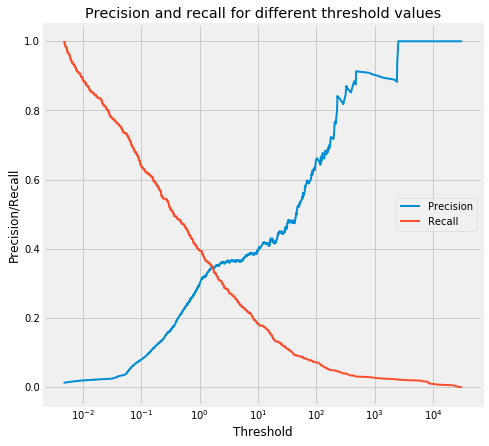

In [61]:
# max precision or recall of model is approx. 0.35 given threshold of 3

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

fig, ax = plt.subplots(figsize=(7,7))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
ax.set_xscale('log')

plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend(loc='best')
plt.show()

In [1]:
# a high recall will give a low precision (and vice versa), depending on the threshold
# model has low precision / recall and is unable to differentiate normal from fraud well 

In [62]:
test_x_pred = autoencoder.predict(df_test_x_rescaled)

mse = np.mean(np.power(df_test_x_rescaled - test_x_pred, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse, 'True_class': df_test['isFraud']})
error_df_test = error_df_test.reset_index()

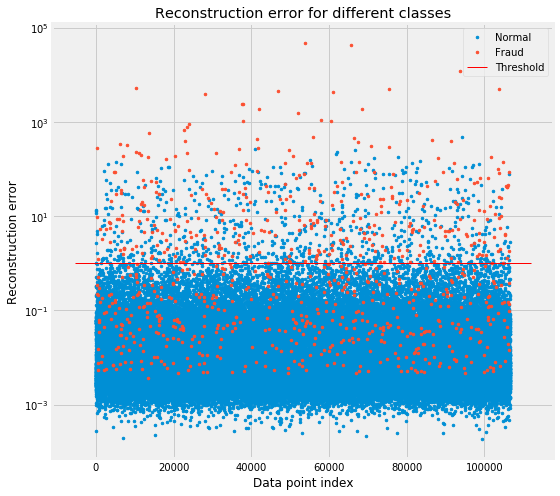

In [63]:
# reconstruct test data, those above threshold recon error will be labelled as 'fraud'

threshold_fixed = 1

fig, ax = plt.subplots(figsize=(8,8))

groups = error_df_test.groupby('True_class')

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=2.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold',linewidth=1)
ax.legend()
ax.set_yscale('log')
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

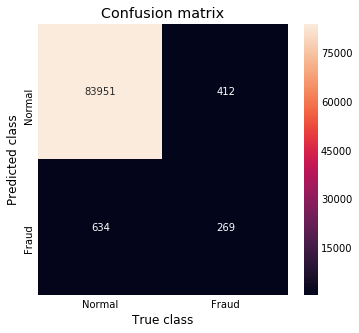

In [64]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix.T, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d")

plt.title("Confusion matrix")
plt.ylabel('Predicted class')
plt.xlabel('True class')
plt.show()

In [65]:
print(classification_report(error_df.True_class, pred_y))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     84585
           1       0.30      0.40      0.34       681

   micro avg       0.99      0.99      0.99     85266
   macro avg       0.65      0.69      0.67     85266
weighted avg       0.99      0.99      0.99     85266



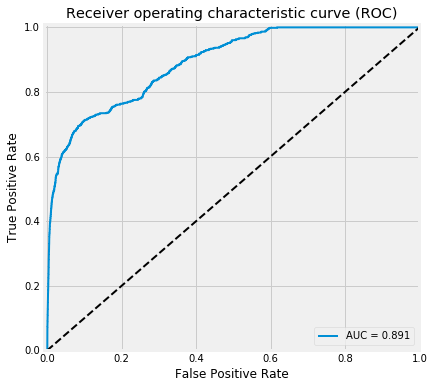

In [66]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)

roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(6,6))
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1], [0,1], 'k--', linewidth=2)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()